# Evaluation on EC3D dataset for squat exercise

## Data processing and angles extraction

In [1]:
import pandas as pd
import numpy as np
import yaml
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
dataset = pd.read_pickle("../data/EC3D/data_3D.pickle")

with open("../configs/pose_estimators.yaml") as file:
    open_pose_data = yaml.safe_load(file)["openpose"]

LABELS_COLUMNS = ["exercise", "subject", "label", "rep", "frame"]

In [3]:
labels = dataset["labels"]
poses = dataset["poses"]

### Labels processing

In [4]:
labels_df = pd.DataFrame(labels, columns=LABELS_COLUMNS)
labels_df["frame"] = np.arange(len(labels_df))
labels_df = labels_df[labels_df["exercise"] == "Lunges"]
labels_df.iloc[:, 2:] = labels_df.iloc[:, 2:].astype("int")

In [5]:
labels_df['label'].unique()

array([1, 6, 4], dtype=object)

### Poses processing

In [20]:
LUNGES_LABELS = {
    1: "correct",
    4: "not_low_enough",
    6: "knee_passes_toe",
}

In [23]:
def get_rep_frames_from_df(labels_df: pd.DataFrame) -> pd.Grouper:
    """Group dataframe by repetition"""
    groups = labels_df.groupby("subject")

    return [
        rep["frame"].values
        for _, subject_group in groups
        for _, rep in subject_group.groupby("rep")
    ]


def get_df_from_frames(
    labels_df: pd.DataFrame, poses: np.ndarray, label: str
) -> pd.DataFrame:
    """Combine joints representations with labels"""
    frames = get_rep_frames_from_df(labels_df)
    final_reps_df = pd.DataFrame()
    for rep_num, frames_rep in enumerate(frames, start=1):
        rep_3d_joints = poses[frames_rep]

        rep_3d_joints_x = rep_3d_joints[:, 0, :15].reshape(-1)
        rep_3d_joints_y = rep_3d_joints[:, 1, :15].reshape(-1)
        rep_3d_joints_z = rep_3d_joints[:, 2, :15].reshape(-1)
        frames_num = len(rep_3d_joints_x) // 15

        rep = np.full_like(rep_3d_joints_x, rep_num, dtype=int)
        frames = np.repeat(np.arange(frames_num, dtype=int), 15)
        joint_names = np.tile(list(open_pose_data["joints"].values()), frames_num)
        labels = np.full_like(rep_3d_joints_x, label, dtype="<U15")
        final_rep = np.array(
            [
                rep,
                frames,
                rep_3d_joints_x,
                rep_3d_joints_y,
                rep_3d_joints_z,
                joint_names,
                labels,
            ]
        ).T
        final_reps_df = pd.concat(
            [
                final_reps_df,
                pd.DataFrame(
                    final_rep,
                    columns=["rep", "frame", "x", "y", "z", "joint_name", "label"],
                ),
            ],
            axis=0,
        )
    final_reps_df["rep"] = final_reps_df["rep"].astype("int")
    final_reps_df["frame"] = final_reps_df["frame"].astype("int")

    return final_reps_df

In [24]:
joints_data = []
for label_number, label_name in LUNGES_LABELS.items():
    joints_data.append(
        get_df_from_frames(
            labels_df[labels_df["label"] == label_number], poses, label_name
        )
    )


joints_df = pd.concat(joints_data)

### Angles extraction

In [25]:
ANGLE_TYPES = {"3D": [0, 1, 2], "front": [1, 2], "side": [0, 1], "top": [0, 2]}


def calculate_angle(
    v1: np.ndarray, v2: np.ndarray, v3: np.ndarray, dims: list = [0, 1, 2]
) -> float:
    if not all(arr.shape == (3,) for arr in (v1, v2, v3)):
        raise ValueError("Input arrays must all be of shape (3,).")
    v1 = v1[dims]
    v2 = v2[dims]
    v3 = v3[dims]

    v21 = v1 - v2
    v23 = v3 - v2

    cosine_angle = np.dot(v21, v23) / (np.linalg.norm(v21) * np.linalg.norm(v23))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)


def extract_angles_from_joints(
    joints_df: pd.DataFrame, angles_formula: dict
) -> pd.DataFrame:
    angles_data = []
    for (label, rep, frame), rep_data in joints_df.groupby(["label", "rep", "frame"]):
        rep_data = rep_data.reset_index()
        angles = {}
        for angle_name, angle_joints in angles_formula.items():
            joints_3d_positions = rep_data.loc[angle_joints][["x", "y", "z"]].astype(
                "float"
            )
            for angle_dims_name, angle_dims in ANGLE_TYPES.items():
                angles[f"{angle_name}_{angle_dims_name}"] = calculate_angle(
                    *joints_3d_positions.values, angle_dims
                )
        angles_data.append(
            pd.Series(
                {
                    "rep": rep,
                    "frame": frame,
                    **angles,
                    "label": label,
                }
            )
        )
    return pd.DataFrame(angles_data)

In [26]:
angles_df = extract_angles_from_joints(joints_df, open_pose_data["angles"])

In [27]:
angles_df.head()

,rep,frame,left_knee_3D,left_knee_front,left_knee_side,left_knee_top,right_knee_3D,right_knee_front,right_knee_side,right_knee_top,...,right_shoulder_top,left_hip_3D,left_hip_front,left_hip_side,left_hip_top,right_hip_3D,right_hip_front,right_hip_side,right_hip_top,label
0,1,0,168.437957,169.707640,124.024730,174.700084,146.456382,146.671748,6.516505,175.969034,...,96.445934,178.421671,178.479294,169.739513,179.541895,170.816802,171.036298,127.063930,177.978939,correct
1,1,1,168.532041,169.696831,130.187439,174.929696,143.503930,143.649118,5.390150,176.515657,...,96.857628,178.020607,178.015438,165.921561,179.855290,168.109669,168.295263,125.157210,177.864143,correct
2,1,2,168.607933,169.727850,136.275969,175.033519,142.005580,142.120594,4.740664,176.804853,...,97.327251,177.240954,177.238334,160.056888,179.779657,165.636504,165.777804,125.594606,177.921566,correct
3,1,3,168.642879,169.806125,141.713367,174.938066,142.131198,142.258614,4.352995,176.620019,...,97.693858,176.112722,176.136346,153.340261,179.460824,163.505269,163.583931,127.246320,178.261544,correct
4,1,4,168.654786,169.942700,146.171269,174.669625,143.875654,144.054808,3.366632,176.092049,...,97.917368,174.707856,174.739453,146.965329,179.273399,161.857729,161.885049,129.222006,178.712371,correct


In [28]:
correct_angles = []
for (label, rep), data in angles_df.groupby(["label", "rep"]):
    if data["label"].iloc[0] == "correct":
        correct_angles.append(data)

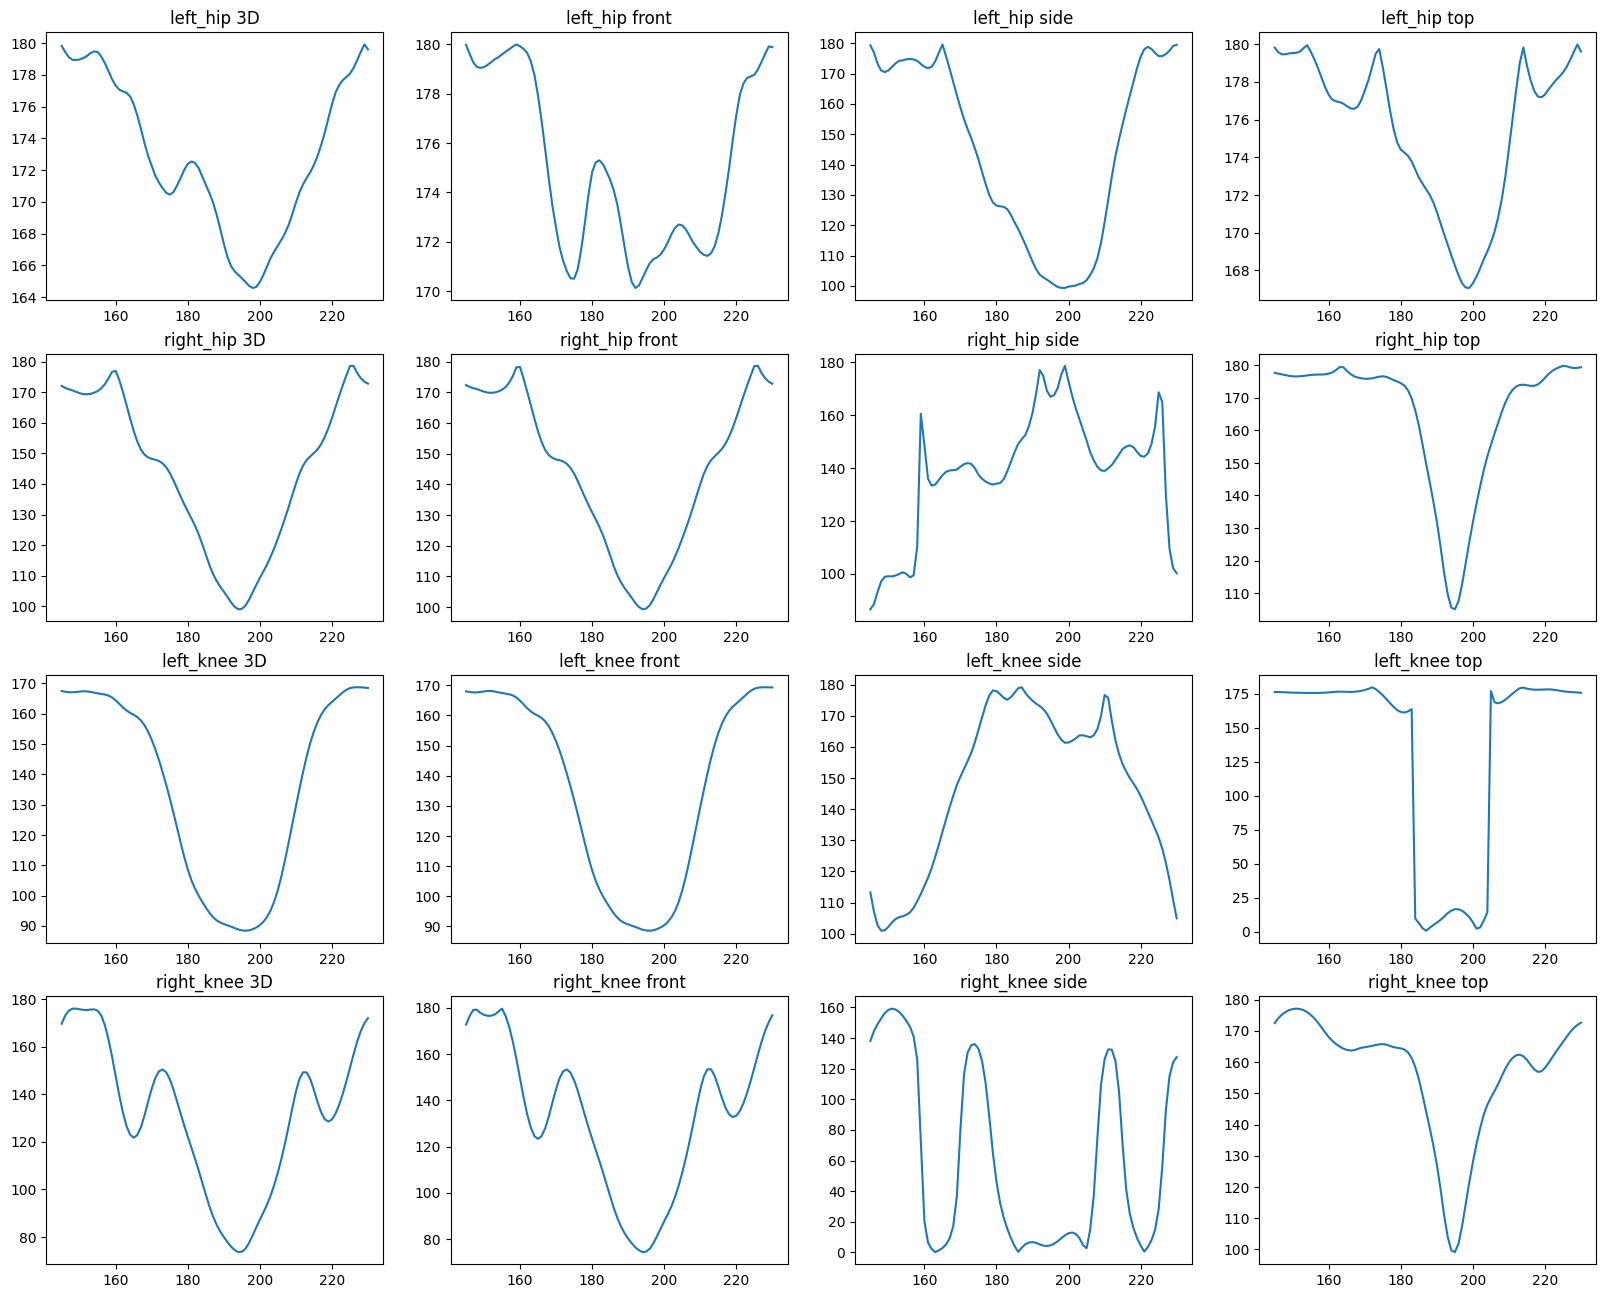

In [30]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20, 16))

angle_types = ["3D", "front", "side", "top"]
squad_angles = ["left_hip", "right_hip", "left_knee", "right_knee"]

for angle, axes in zip(squad_angles, ax):
    for angle_type, axis in zip(angle_types, axes):
        axis.plot(correct_angles[2][f"{angle}_{angle_type}"])
        axis.set_title(f"{angle} {angle_type}")

## Angles comparison

Comparison will be presented between **correct** and **not low enough** labels

### Correct and incorrect samples extraction

In [ ]:
def get_sample(df: pd.DataFrame, label: str) -> pd.DataFrame:
    for _, sample in df.groupby(["label", "rep"]):
        if sample["label"].iloc[0] == label:
            return sample.reset_index()
    return pd.DataFrame()

In [ ]:
correct_sample = get_sample(angles_df, "correct")
incorrect_sample = get_sample(angles_df, "not_low_enough")

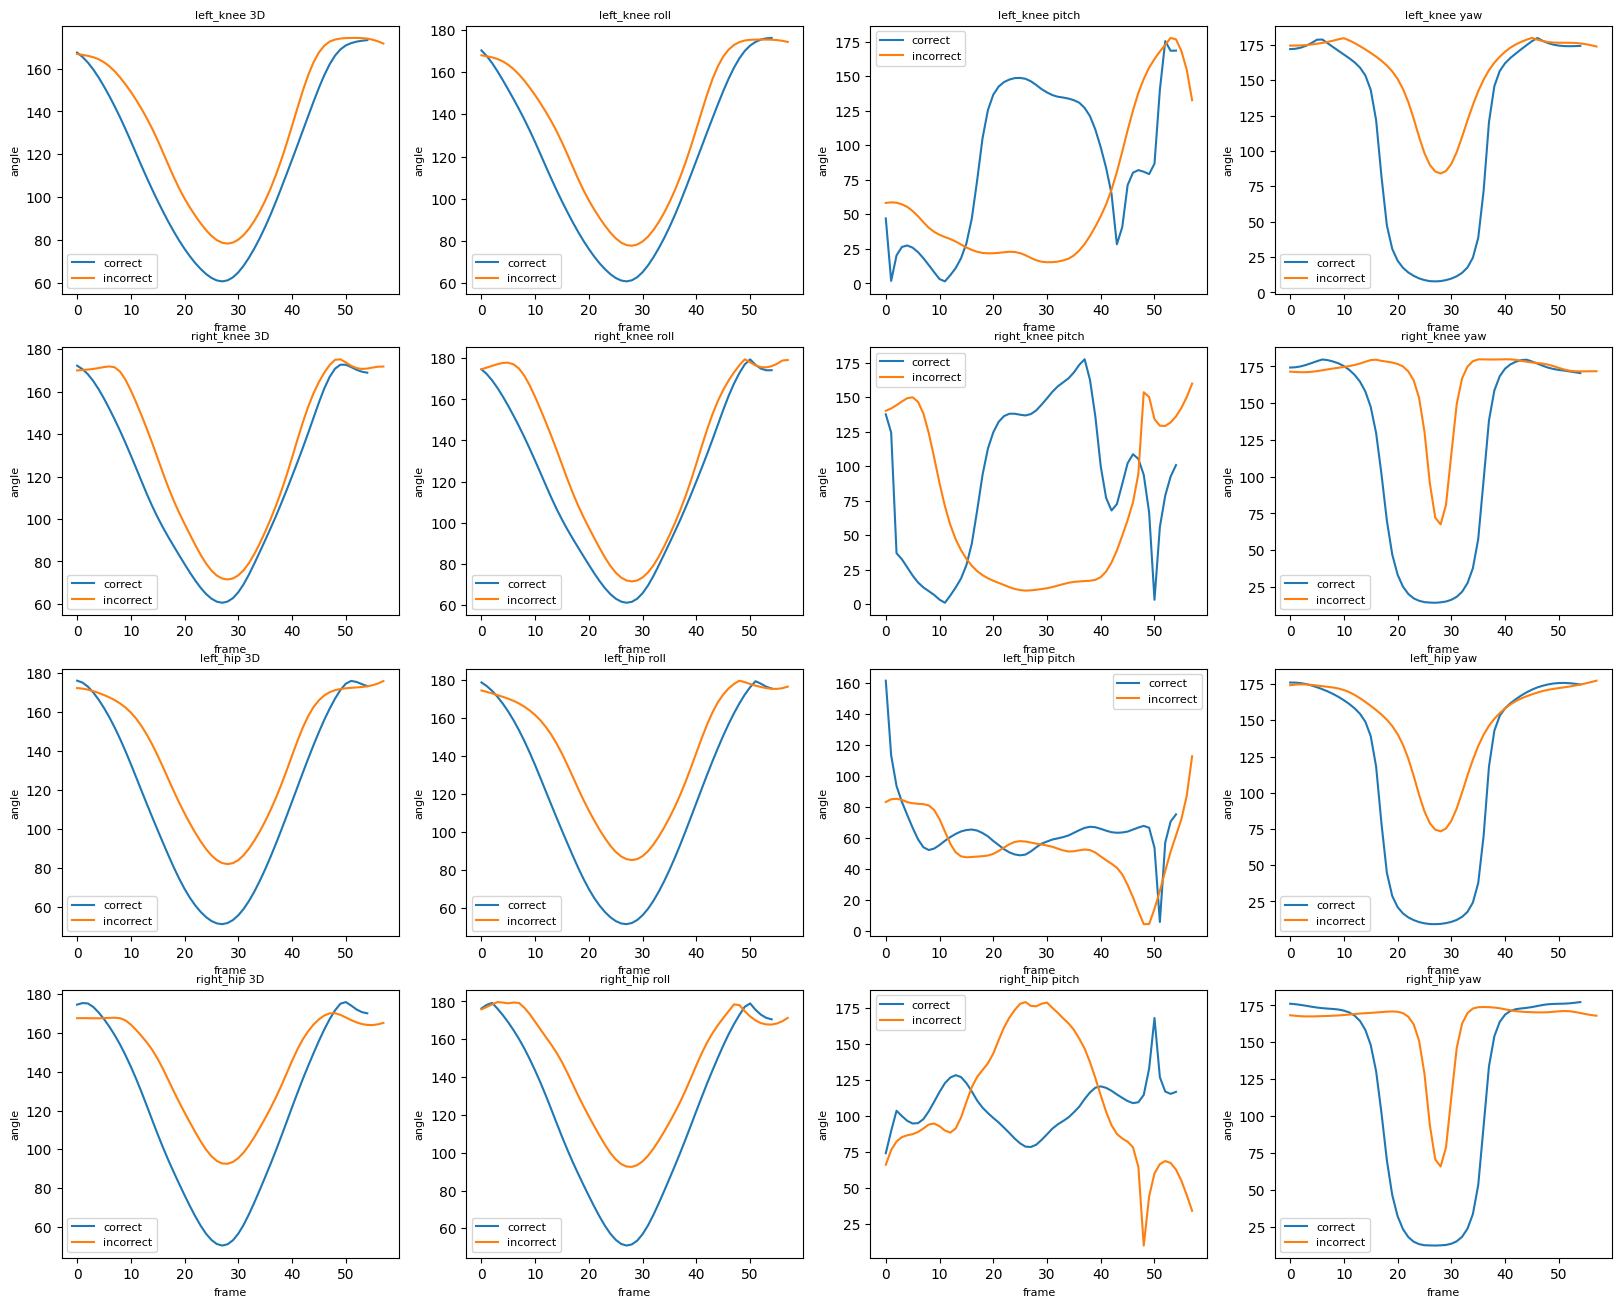

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))

considered_angles = ["left_knee", "right_knee", "left_hip", "right_hip"]

for angle_axes, angle in zip(axes, considered_angles):
    for axis, angle_type in zip(angle_axes, ANGLE_TYPES.keys()):
        axis.plot(correct_sample[f"{angle}_{angle_type}"], label="correct")
        axis.plot(incorrect_sample[f"{angle}_{angle_type}"], label="incorrect")
        axis.legend(fontsize=8)
        axis.set_title(f"{angle} {angle_type}", fontsize=8)
        axis.set_xlabel("frame", fontsize=8)
        axis.set_ylabel("angle", fontsize=8)

It is clearly visible that pitch rotation provides best information for this kind of incorrection analysis. 

### DTW alignment

In [ ]:
from tslearn.metrics import dtw_path


def get_warped_frame_indexes(query: np.ndarray, reference: np.ndarray) -> list:
    path, _ = dtw_path(query, reference)
    path = np.array(path)
    return path


def filter_repetable_reference_indexes(
    referene_to_query: np.ndarray, query_to_refernce: np.ndarray
) -> np.ndarray:
    query_to_refernce_cp = query_to_refernce.copy()

    for idx in range(len(referene_to_query) - 1, -1, -1):
        if idx > 0 and referene_to_query[idx] == referene_to_query[idx - 1]:
            query_to_refernce_cp = np.delete(query_to_refernce_cp, idx)

    return query_to_refernce_cp

ModuleNotFoundError: No module named 'tslearn'

In [ ]:
dtw_alignment = get_warped_frame_indexes(
    incorrect_sample["right_knee_pitch"], correct_sample["right_knee_pitch"]
)
query_to_reference_warping = filter_repetable_reference_indexes(
    dtw_alignment[:, 1], dtw_alignment[:, 0]
)

diffs = [
    correct_sample["right_knee_pitch"][reference_idx]
    - incorrect_sample["right_knee_pitch"][query_idx]
    for reference_idx, query_idx in enumerate(query_to_reference_warping)
]

### DTW diffs visualization

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))

considered_angles = ["left_knee", "right_knee", "left_hip", "right_hip"]

for angle_axes, angle in zip(axes, considered_angles):
    for axis, angle_type in zip(angle_axes, ANGLE_TYPES.keys()):
        angle_key = f"{angle}_{angle_type}"
        dtw_alignment = get_warped_frame_indexes(
            incorrect_sample[angle_key], correct_sample[angle_key]
        )
        query_to_reference_warping = filter_repetable_reference_indexes(
            dtw_alignment[:, 1], dtw_alignment[:, 0]
        )

        diffs = [
            correct_sample[angle_key][reference_idx]
            - incorrect_sample[angle_key][query_idx]
            for reference_idx, query_idx in enumerate(query_to_reference_warping)
        ]
        axis.plot(diffs)
        axis.set_title(f"DTW difference {angle} {angle_type}", fontsize=8)
        axis.set_xlabel("frame", fontsize=8)
        axis.set_ylabel("DTW angle diff", fontsize=8)